In [1]:
import igl
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math as m
import itertools
import random

from meshplot import plot, subplot, interact

import os
root_folder = os.getcwd()

In [2]:
import matlab.engine
import matlab
eng = matlab.engine.start_matlab()

In [3]:
shading = { "wireframe":True,
               "scale": 1,
               "side": "FrontSide"}

In [4]:
def unit_vector(vector):
    """ Returns the unit vector of the vector."""
    return vector / np.linalg.norm(vector)

def x_rotation(vector,theta):
    """Rotates 3-D vector around x-axis"""
    R = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0, np.sin(theta), np.cos(theta)]])
    return np.dot(R,vector)

def y_rotation(vector,theta):
    """Rotates 3-D vector around y-axis"""
    R = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0, np.cos(theta)]])
    return np.dot(R,vector)

def z_rotation(vector,theta):
    """Rotates 3-D vector around z-axis"""
    R = np.array([[np.cos(theta), -np.sin(theta),0],[np.sin(theta), np.cos(theta),0],[0,0,1]])
    return np.dot(R,vector)

In [5]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / m.sqrt(np.dot(axis, axis))
    a = m.cos(theta / 2.0)
    b, c, d = -axis * m.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [6]:
def rot_angles(nbranch):
    """Euler angles to rotate vector 'nbranch' to coincide with the z-axis"""
    nbranchxy = unit_vector(np.array([nbranch[0],nbranch[1]]))
    phi = np.arccos(nbranchxy[0])
    if (nbranch[1]!=0):
        nrot1 = z_rotation(nbranch,-np.sign(nbranch[1])*phi)
    else: 
        nrot1 = z_rotation(nbranch,phi)
    nbranchxz = unit_vector(np.array([nrot1[0],nrot1[2]]))
    theta = np.arccos(nbranchxz[1])
    nrot2 = y_rotation(nrot1,-theta)
    return theta, phi

def angle_between(v1, v2):
    """Finds angle between two vectors"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def change_frame(vec,theta,phi,nbranch):
    """Rotate vector in the new frame that we find in rot_angles"""
    if (nbranch[1]!=0):
        vecrot1 = z_rotation(vec,-np.sign(nbranch[1])*phi)
    else:
        vecrot1 = z_rotation(vec,phi)
    vecrot2 = y_rotation(vecrot1,-theta)
    return vecrot2

In [7]:
def cart2sph(x,y,z):
    XsqPlusYsq = x**2 + y**2
    r = m.sqrt(XsqPlusYsq + z**2)               # r
    theta = m.atan2(z,m.sqrt(XsqPlusYsq))     # theta
    phi = m.atan2(y,x)                           # phi
    return r, theta, phi

def sph2cart(r,theta,phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)           
    z = r*np.cos(theta)     
    return x,y,z

In [8]:
def branching_nodes(v,bv,nb,l_br,l_brvar,nplane):

    vnode = []
    infvnode = []
    #Normal vectors of the parallel planes (needs to be generalized after branching after branches?):
    rff = max(bv[:])
    #Identify the vertices that belong at each branch 
    for rj in range(rff+1):
        jb = np.where(bv == rj)
        vb = v[jb[0]]
        #Number of nodes at each branch
        imax = np.argmax(vb[:,2])
        imin = np.argmin(vb[:,2])
        l_brtot = np.sqrt(sum((vb[imax]-vb[imin])**2))
        nnodes = int(l_brtot/l_br)
        #Conditions for the vertex inside the two parallel planes: 
        for jn in range(nnodes-1):
            #Points that define the planes:
            lnode = float((jn+1)*l_br)
            xplane1 = vb[imin] + (lnode-l_brvar)*nb[rj]
            xplane2 = vb[imin] + (lnode+l_brvar)*nb[rj]
            #Is the point between planes)           
            P1 = np.dot(vb-xplane1, nplane[rj,:])
            P2 = np.dot(vb-xplane2, nplane[rj,:])
            inode = np.where((P1 >0) & (P2 < 0)) 
            #Appending the vertices of each node
            if (len(inode[0])!= 0):
                vnode.append(vb[inode])
                ###This last "for" could be avoided###
                for jv in range(len(inode[0])):
                    infvnodeant = [jb[0][inode[0][jv]],rj,jn]
                    infvnode.append(infvnodeant)

                # a versions anteriors hi ha com es monta vnode amb indexos corresponent a
                # la branca i el node, i despres esta dibuixats al plot, on s'explica
                # com es corre pels indexos.
                # aixi pot ser seria mes rapid de triar el vector que creix. 

                    
    # vnode: contains the spatial positions of all the vertices in any of the nodes
    # infvnode: contains the info about the label, branch, and node of the vertices in vnode
    return vnode,infvnode

In [9]:
def var_to_matlab(v,f,n,b):
    f = f+1
    fl = f.tolist()
    bl = b.tolist()
    vl = v.tolist()
    nl = n.tolist()
    vld = matlab.double(vl)
    fld = matlab.double(fl)
    bld = matlab.double(bl)
    nld = matlab.double(nl)
    return vld,fld,nld,bld

def var_to_python(v,f,n,b):
    vpy = np.array(v)
    fpy = np.array(f)-1
    bpy = np.array(b)
    npy = np.array(n)
    fpy = fpy.astype(int)
    return vpy,fpy,npy,bpy

In [10]:
def relabel_b(ffuse,fpy,bpy,indexv):
    # we have to elimnate the components of b corresponding to the eliminated faces
    # the function igl.remove_duplicates does only return "indexv", the vertices that have been matched 
    # we compare the two faces arrays (ffuse and fpy), to find out the eliminated faces and correct b
    # (it could be done faster for sure...)
    ffuse_rep = indexv[fpy]
    ii = -1
    jj = -1
    bb = [[]]
    for i in range(len(ffuse_rep)):
        ii = ii + 1
        jj = jj + 1
        if any(ffuse[ii] != ffuse_rep[jj]):
            ii = ii - 1
        else:
            bb = np.append(bb, [bpy[[jj]]])
    b = np.reshape(bb,(len(bb),1))
    return b

In [11]:
# Program to find most frequent
# element in a list
def most_frequent(List):
    return max(set(List), key = List.count)

def flatten_list(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


# all elements in a list are identical
def check_identical(list):
    return all(i == list[0] for i in list)

In [12]:
def coral(dmax,dminp,amin,itf,elong,smin,smax,angle_br,l_br,l_brvar,pbr,rand_seed):
    
    #things that I changed to get good branches... 
        #-height of the base
        #-dmax = 1 (fixed)
        #-smax
        #-eliminate fusion
    #hauria d'esbrinar quines son importants
    
    hbase = 0.5
    random.seed(rand_seed)
    
    #ORIGINAL SEED
    dmin = dminp*dmax
    vi = np.array([
        [0., 0., hbase],
        [np.cos(0),np.sin(0),0],
        [np.cos(np.pi/3),np.sin(np.pi/3),0],
        [np.cos(2*np.pi/3),np.sin(2*np.pi/3),0],
        [np.cos(np.pi),np.sin(np.pi),0],
        [np.cos(4*np.pi/3),np.sin(4*np.pi/3),0],
        [np.cos(5*np.pi/3),np.sin(5*np.pi/3),0]])
    vi = dmax*vi
    fi = np.array([
        [0, 1, 2],
        [0, 2, 3],
        [0, 3, 4],
        [0, 4, 5],
        [0, 5, 6],
        [0, 6, 1]])
    ni = igl.per_vertex_normals(vi,fi)
    for i in range(len(vi)):
        if vi[i][2] == 0:
           ni[i][2] = 0
           ni[i] = ni[i]/np.linalg.norm(ni[i])  
    bi = np.array([
    [0.],
    [0.],
    [0.],
    [0.],
    [0.],
    [0.]])
    bvi = np.array([0,0,0,0,0,0,0])
    
    #INITIALISATION
    vs = [vi]
    fs = [fi]
    v = vi
    f = fi
    n = ni
    nfused = 0
    nfused_a = 0
    
    bld = []
    occ_nodes = []
    b = np.copy(bi)
    bv = np.copy(bvi)
    bvs = [np.copy(bvi)]
    nb = np.array([[0,0,1.]])
    nplane = np.array([[0,0,1.]])
    phi = [0]
    theta = [0]
    rf = 0
    
    for it in range(itf):
        for i in range(len(v)):
            r = bv[i]
            if r != -1:
                nm = change_frame(n[i],theta[r],phi[r],nb[r])
                chi = nm[2]/np.sqrt(nm[0]**2 + nm[1]**2)
                chilog = (2/np.pi)*np.arctan(chi)
                if chilog >= smin and chilog <= smax :
                    v[i] = v[i] + elong*n[i] 
        pbr_tot = pbr*max(bv+1)
        rand = random.random()
        if pbr_tot>rand:
            #print('tried branching',it, pbr_tot)
            [vnode,inode] = branching_nodes(v,bv,nb,l_br,l_brvar,nplane)
            nvnode = len(inode)
            for i in range(nvnode):
                #print('branched')
                irand = random.randint(0,nvnode-1)
                # This random number corresponde to the vector with label
                ir = inode[irand][0]
                actual_node = [inode[irand][1], inode[irand][2]]
                if not any(elem in [actual_node] for elem in occ_nodes):
                    if (n[ir,2] > 0): ####it loops until it finds a vertex with 
                        rf = rf + 1
                        # update the list of occupied nodes
                        occ_nodes.append(actual_node)
                        #Axis of rotation:
                        #cross product of the (n-1)-level branch and current directional vect
                        nbant = nb[bv[ir]]
                        axis = np.cross(nbant,n[ir])
                        theta_br = angle_br*np.pi/180
                        #Rotate a vector nbant around an axis: 
                        nbnow = np.dot(rotation_matrix(axis, theta_br), nbant)
                        nbnow = unit_vector(nbnow)
                        nb = np.append(nb, [nbnow], axis=0)
                        #Make the vertex branch along the new direction
                        v[ir] = v[ir] + 1*nb[rf]
                        #Finding the frame transformation to rotate to nz-axis
                        (thetai, phii) = rot_angles(nb[rf]) 
                        theta = np.append(theta,thetai)
                        phi = np.append(phi,phii)
                        #Normal vector to the parallel planes (using previous axis):
                        nplanenow = np.dot(rotation_matrix(axis, np.pi/2), nbant)
                        nplanenow = unit_vector(nplanenow)
                        nplane = np.append(nplane, [nplanenow], axis=0)
                        #collindant faces to the ramified vertex
                        [fx,nx]=igl.vertex_triangle_adjacency(f,len(v))
                        newb = fx[nx[ir]:nx[ir+1]]
                        b[newb] = rf
                        break ##### to stop when nz is positive, and the node is not occupied
        
        ###SUBDIVIDE & FUSE 
        # 1) SUBDIVIDE
        # recalculate normals (growth and subdiv need different normals for the base)
        n = igl.per_vertex_normals(v,f)
        # translate variables to matlab
        [v_mat,f_mat,n_mat,b_mat] = var_to_matlab(v,f,n,b)
        # SUBDIVIDE (in matlab)
        [vsub, fsub, bsub] = eng.subdiv_total(v_mat, f_mat, b_mat, n_mat, dmax, nargout = 3)
        # return variables to python 
        [vsub_py,fsub_py,nsub_py,bsub_py] = var_to_python(vsub,fsub,n_mat,bsub)
        
        # 2) FUSE vertices that are close
        [vfuse,ffuse,indexv] = igl.remove_duplicates(vsub_py,fsub_py,dmin)
        # after the elimination of faces, b needs correction. 
        bfuse = relabel_b(ffuse,fsub_py,bsub_py,indexv)
 
        # 3) COLLAPSE elongated triangles
        # we compute the (double) areas of all the triangles
        dblA = igl.doublearea(vfuse, ffuse)
        # translate variables to matlab
        [v_mat,f_mat,dblA_mat,b_mat] = var_to_matlab(vfuse,ffuse,dblA,bfuse)
        # eliminate small triangles that have not been eliminated in fusion
        [fcollapse, indexv] = eng.collapse_small_triangles(v_mat, f_mat, dblA_mat, amin, nargout = 2)
        # return variables to python (only need f and indexv)
        [v_py,fcollapse_py,v_py,v_py] = var_to_python(v_mat,fcollapse,v_mat,v_mat)
        [v_py,indexv_py,v_py,v_py] = var_to_python(v_mat,indexv,v_mat,v_mat)
        # after the elimination of faces, b needs correction. 
        bcollapse = relabel_b(fcollapse_py,ffuse,bfuse,indexv_py[0])
        # the function eng.collapse_small_triangles does not correct v  
        [v, f, x, y] = igl.remove_unreferenced(v_py,fcollapse_py)
        b = bcollapse
        nfused = nfused + (len(vsub_py)-len(vfuse))
        nfused_a = nfused_a + (len(vfuse)-len(v))

        ### FIX GROUND
        n = igl.per_vertex_normals(v,f)
        for i in range(len(v)):
            if v[i][2] == 0:
                n[i][2] = 0
                n[i] = n[i]/np.linalg.norm(n[i])
        ### LABEL VERTEX WITH BRANCH (optimizar)
        bv.resize((len(v)),refcheck=False)
        [fx,nx]=igl.vertex_triangle_adjacency(f,len(v))
        for k in range(len(v)): 
            badj = b[fx[nx[k]:nx[k+1]]]
            badj = flatten_list(badj.tolist())
            if check_identical(badj):
                bv[k] = badj[0]
            #Choose which is the branch each vertex belongs at the node. 
            #very intrincated writing
            else:
                r1 = int(min(badj))
                nm = change_frame(n[k],theta[r1],phi[r1],nb[r1])
                chi = nm[2]/np.sqrt(nm[0]**2 + nm[1]**2)
                chilog = (2/np.pi)*np.arctan(chi)
                if chilog >= smin and chilog <= smax:
                    r2 = int(max(badj))
                    nm = change_frame(n[k],theta[r2],phi[r2],nb[r2])
                    chi = nm[2]/np.sqrt(nm[0]**2 + nm[1]**2)
                    chilog = (2/np.pi)*np.arctan(chi)
                    if chilog >= smin and chilog <= smax:
                        bv[k] = -1
                    else:
                        bv[k] = r2
                else:
                    bv[k] = r1
                    #print(bv[k])
        
        vs.append(v)
        fs.append(f)
        bvs.append(bv)
        
    [vnode,inode] = branching_nodes(v,bv,nb,l_br,l_brvar,nplane) 


    shading = { "wireframe":True,
               "scale": 1,
               "side": "FrontSide"}
    print('nfused=', nfused)
    print('nfused_area=', nfused_a)

    
    return [vs,fs,bvs]
    #return the whole vs, fs, bvs


In [13]:

dmax = 1
dminp = 0.2
amin = 0.0
tf = 320
elong = 0.1
smin = 0.38
smax = 1
angle_br = 60
l_br = 6
l_bre = 0.25
#pbr = 0
pbr = elong/l_br
rand_seed = 150


[vs,fs,bvs] = coral(dmax,dminp,amin,tf,elong,smin,smax,angle_br,l_br,0.25*l_br,pbr,rand_seed)


nfused= 1
nfused_area= 0


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import imageio
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource

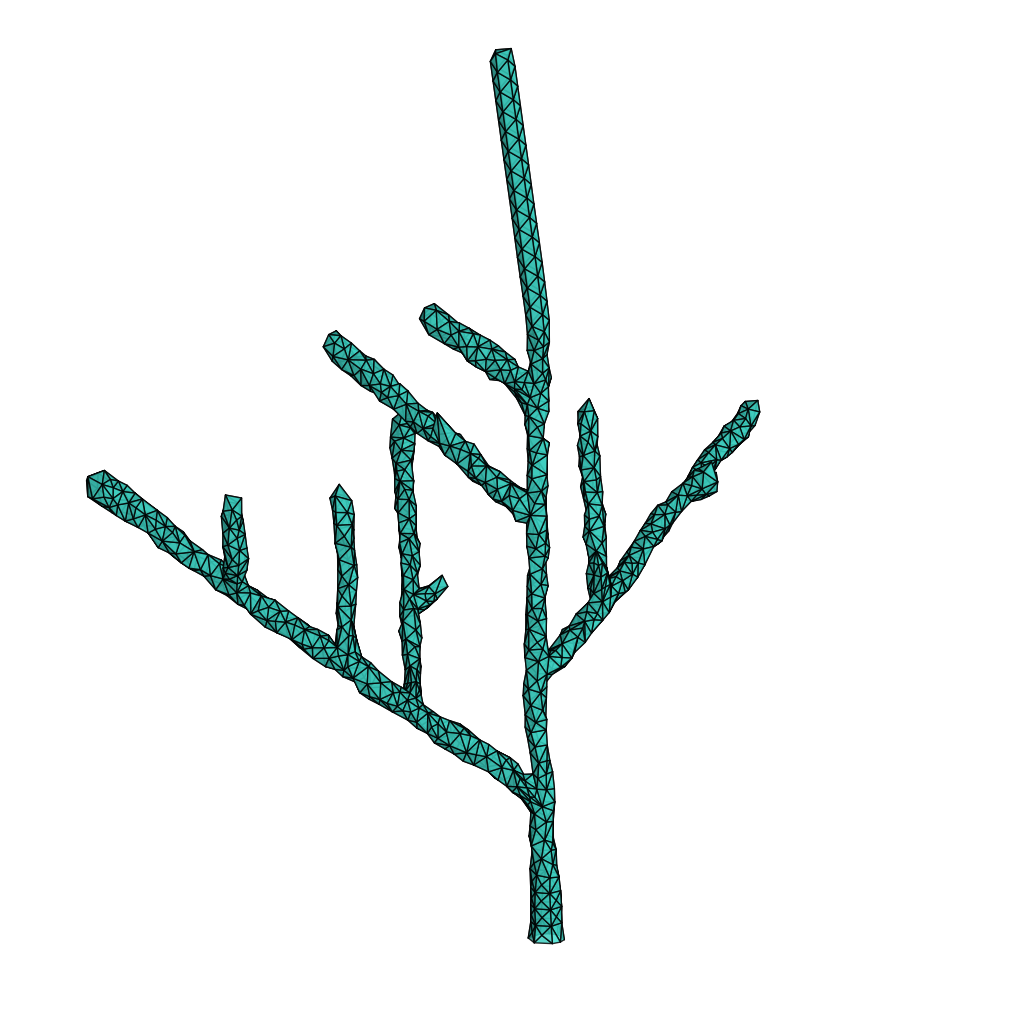

In [18]:
r = tf-1
x1 = []
for i in range(len(vs[r])):
    x1 = np.append(x1, vs[r][i][0])
y1 = []
for i in range(len(vs[r])):
    y1 = np.append(y1, vs[r][i][1])
z1 = []
for i in range(len(vs[r])):
    z1 = np.append(z1, vs[r][i][2])
    
X = x1
Y = y1 
Z = z1
fig = plt.figure(figsize=(10,10), constrained_layout=True)
ax = plt.axes(projection='3d')

ax.set_xlim(-1.5,1.8)
ax.set_ylim(-1.5,1.5)
ax.set_zlim(10,30)
ax.set_axis_off()

def short_proj():
  return np.dot(Axes3D.get_proj(ax), scale)
x_scale=2
y_scale=2
z_scale=20
scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0
ax.get_proj=short_proj

azimutal_rot = 100
elevation_rot = 10
ax.view_init(elevation_rot, azimutal_rot)
ls = LightSource(azdeg=azimutal_rot+220, altdeg=elevation_rot)

s = ax.plot_trisurf(X, Y, Z, triangles=fs[r],
                    color='turquoise', shade = 'True', lightsource = ls, alpha = 0.83, edgecolor='k')
#plt.colorbar(s, shrink=0.7)
fig.canvas.draw()
image2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image2 = image2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

plt.savefig("branching_d60.l6.png") 
plt.show()